In [1]:
graph_feat_size = 256
n_tasks = 1
dropout_g = 0.5
dropout_f = 0.5
dropout_l = 0.5

In [2]:
import pandas as pd
import numpy as np
import os
import random
import copy
import dgl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from dgllife.model import model_zoo
from dgllife.utils import smiles_to_bigraph
from dgllife.utils import EarlyStopping, Meter
from dgllife.utils import AttentiveFPAtomFeaturizer, AttentiveFPBondFeaturizer
from dgllife.data import MoleculeCSVDataset
from dgllife.model.gnn import AttentiveFPGNN
from dgllife.model.readout import AttentiveFPReadout
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

if torch.cuda.is_available():
    print('use GPU')
    device = 'cuda'
else:
    print('use CPU')
    device = 'cpu'

seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
n_feats = atom_featurizer.feat_size('hv')
e_feats = bond_featurizer.feat_size('he')
print("n_feats", n_feats, "e_feats", e_feats)

E:\Anaconda\envs\dye37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


use GPU
n_feats 39 e_feats 10


In [3]:
def load_data_with_fp(data, fp_data, name, load):
    dataset = MoleculeCSVDataset(data,
                                 smiles_to_graph=smiles_to_bigraph,
                                 node_featurizer=atom_featurizer,
                                 edge_featurizer=bond_featurizer,
                                 smiles_column='SMILES',
                                 cache_file_path=str(name)+'_dataset_AM.bin',
                                 task_names=['AM'],
                                 load=load, init_mask=True, n_jobs=1
                                )

    combined_data = []
    for i, data_tuple in enumerate(dataset):
        if len(data_tuple) == 3:
            smiles, graph, label = data_tuple
            mask = None
        else:
            smiles, graph, label, mask = data_tuple
        fp = torch.tensor(fp_data[i], dtype=torch.float32)
        combined_data.append((graph, fp, label, mask))
    return combined_data

In [4]:
def load_fingerprints(fp_file):
    df = pd.read_csv(fp_file, header=None)
    return torch.tensor(df.values, dtype=torch.float32)
    
train_data = pd.read_csv('./Data/train-AM.csv')
valid_data = pd.read_csv('./Data/valid-AM.csv')

scaler = StandardScaler()
train_data[['AM']] = scaler.fit_transform(train_data[['AM']])
valid_data[['AM']] = scaler.transform(valid_data[['AM']])

train_fp = load_fingerprints('./Data/train-AM-morgan.csv')
valid_fp = load_fingerprints('./Data/valid-AM-morgan.csv')

train_datasets = load_data_with_fp(train_data, train_fp, 'train', True)
valid_datasets = load_data_with_fp(valid_data, valid_fp, 'valid', True)

Loading previously saved dgl graphs...


E:\Anaconda\envs\dye37\lib\site-packages\ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Loading previously saved dgl graphs...


In [5]:
class GraphFingerprintsModel(nn.Module):
    def __init__(self, node_feat_size, edge_feat_size, fp_size, 
                 graph_feat_size=graph_feat_size, num_layers=2, num_timesteps=2, 
                 n_tasks=1, dropout_g=0, dropout_f=0, dropout_l=0):
        super(GraphFingerprintsModel, self).__init__()

        self.gnn = AttentiveFPGNN(node_feat_size=node_feat_size,
                                  edge_feat_size=edge_feat_size,
                                  num_layers=num_layers,
                                  graph_feat_size=graph_feat_size,
                                  dropout=dropout_g)
        self.readout = AttentiveFPReadout(feat_size=graph_feat_size,
                                          num_timesteps=num_timesteps,
                                          dropout=dropout_g)

        self.fp_fc = nn.Sequential(
            nn.Linear(fp_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_f),
            nn.Linear(256, graph_feat_size)
        )

        self.predict = nn.Sequential(
            nn.Dropout(dropout_l),
            nn.Linear(graph_feat_size * 2, 128),
            nn.ReLU(),
            nn.Linear(128, n_tasks)
        )
        
    def forward(self, g, node_feats, edge_feats, fingerprints):
        if edge_feats is None or 'he' not in g.edata.keys():
            num_edges = g.number_of_edges()
            edge_feats = torch.zeros((num_edges, e_feats)).to(g.device)  # 分配全零边特征
        node_feats = self.gnn(g, node_feats, edge_feats)
        graph_feats = self.readout(g, node_feats)
        fp_feats = self.fp_fc(fingerprints)
        combined_feats = torch.cat([graph_feats, fp_feats], dim=1)
        return self.predict(combined_feats)

In [6]:
class MolecularDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn(batch):
    graphs, fps, labels, masks = zip(*batch)
    graphs = dgl.batch(graphs)
    fps = torch.stack(fps)
    labels = torch.stack(labels)
    masks = torch.stack(masks) if masks[0] is not None else None
    return graphs, fps, labels, masks

In [7]:
def train_model(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for graphs, fps, labels, masks in dataloader:
        graphs = graphs.to(device)
        fps = fps.to(device)
        labels = labels.to(device)
        masks = masks.to(device) if masks is not None else None

        node_feats = graphs.ndata['hv']
        edge_feats = graphs.edata['he']

        predictions = model(graphs, node_feats, edge_feats, fps)

        if masks is not None:
            loss = (criterion(predictions, labels) * masks).mean()
        else:
            loss = criterion(predictions, labels)
        
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)

In [8]:
def main():

    node_feat_size = n_feats
    edge_feat_size = e_feats
    graph_feat_size = 256
    num_layers = 2
    num_timesteps = 2
    fp_size = train_fp.shape[1]
    n_tasks = 1
    dropout_g = 0.4
    dropout_f = 0.5
    dropout_l = 0.4
    batch_size = 32
    learning_rate = 1e-3
    epochs = 200
    patience = 20

    model = GraphFingerprintsModel(node_feat_size=node_feat_size,
                                   edge_feat_size=edge_feat_size,
                                   graph_feat_size=graph_feat_size,
                                   num_layers=num_layers,
                                   num_timesteps=num_timesteps,
                                   fp_size=fp_size,
                                   n_tasks=n_tasks,
                                   dropout_g=dropout_g,
                                   dropout_f=dropout_f,
                                   dropout_l=dropout_l).to(device)

    train_dataset = MolecularDataset(train_datasets)
    valid_dataset = MolecularDataset(valid_datasets)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_since_improvement = 0

    for epoch in range(1, epochs + 1):
        train_loss = train_model(model, train_loader, optimizer, criterion)
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for graphs, fps, labels, masks in valid_loader:
                graphs = graphs.to(device)
                fps = fps.to(device)
                labels = labels.to(device)
                if masks is not None:
                    masks = masks.to(device)

                node_feats = graphs.ndata['hv']
                edge_feats = graphs.edata['he']

                predictions = model(graphs, node_feats, edge_feats, fps)
                if masks is not None:
                    loss = (criterion(predictions, labels) * masks).mean()
                else:
                    loss = criterion(predictions, labels)

                val_loss += loss.item()

            val_loss /= len(valid_loader)
            print(f'Epoch {epoch}, Validation Loss: {val_loss:.4f}')

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_since_improvement = 0
                best_model_wts = copy.deepcopy(model.state_dict())
            else:
                epochs_since_improvement += 1
                if epochs_since_improvement >= patience:
                    print("Early stopping triggered.")
                    break

    torch.save(best_model_wts, 'Model_AM.pth')
    print('Model parameters saved')

if __name__ == '__main__':
    main()

Epoch 1, Train Loss: 0.3078
Epoch 1, Validation Loss: 0.1511
Epoch 2, Train Loss: 0.1125
Epoch 2, Validation Loss: 0.0849
Epoch 3, Train Loss: 0.0828
Epoch 3, Validation Loss: 0.0776
Epoch 4, Train Loss: 0.0645
Epoch 4, Validation Loss: 0.0614
Epoch 5, Train Loss: 0.0554
Epoch 5, Validation Loss: 0.0582
Epoch 6, Train Loss: 0.0526
Epoch 6, Validation Loss: 0.0569
Epoch 7, Train Loss: 0.0495
Epoch 7, Validation Loss: 0.0556
Epoch 8, Train Loss: 0.0495
Epoch 8, Validation Loss: 0.0502
Epoch 9, Train Loss: 0.0479
Epoch 9, Validation Loss: 0.0566
Epoch 10, Train Loss: 0.0416
Epoch 10, Validation Loss: 0.0600
Epoch 11, Train Loss: 0.0394
Epoch 11, Validation Loss: 0.0483
Epoch 12, Train Loss: 0.0374
Epoch 12, Validation Loss: 0.0502
Epoch 13, Train Loss: 0.0368
Epoch 13, Validation Loss: 0.0508
Epoch 14, Train Loss: 0.0356
Epoch 14, Validation Loss: 0.0446
Epoch 15, Train Loss: 0.0327
Epoch 15, Validation Loss: 0.0467
Epoch 16, Train Loss: 0.0329
Epoch 16, Validation Loss: 0.0515
Epoch 17, 

# The model's results on the training set and validation set.

In [9]:
train_dataset = MolecularDataset(train_datasets)
valid_dataset = MolecularDataset(valid_datasets)
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, collate_fn=collate_fn)

In [10]:
fp_size = train_fp.shape[1]
model = GraphFingerprintsModel(node_feat_size=n_feats,
                               edge_feat_size=e_feats,
                               graph_feat_size=graph_feat_size,
                               num_layers=2,
                               num_timesteps=2,
                               fp_size=fp_size,
                               n_tasks=1,
                               dropout_g=dropout_g,
                               dropout_f=dropout_f,
                               dropout_l=dropout_l).to(device)

model.load_state_dict(torch.load('Model_AM.pth', map_location=device))
model.eval()

GraphFingerprintsModel(
  (gnn): AttentiveFPGNN(
    (init_context): GetContext(
      (project_node): Sequential(
        (0): Linear(in_features=39, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge1): Sequential(
        (0): Linear(in_features=49, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge2): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Linear(in_features=512, out_features=1, bias=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (attentive_gru): AttentiveGRU1(
        (edge_transform): Sequential(
          (0): Dropout(p=0.5, inplace=False)
          (1): Linear(in_features=256, out_features=256, bias=True)
        )
        (gru): GRUCell(256, 256)
      )
    )
    (gnn_layers): ModuleList(
      (0): GNNLayer(
        (project_edge): Sequential(
          (0): Dropout(p=0.5, inplace=False)
          (1): Linear(in_features=512, out_f

In [11]:
def predict(model, dataloader):
    all_predictions = []
    with torch.no_grad():
        for graphs, fps, _, _ in dataloader:
            graphs = graphs.to(device)
            fps = fps.to(device)

            node_feats = graphs.ndata['hv']
            edge_feats = graphs.edata['he']

            predictions = model(graphs, node_feats, edge_feats, fps)
            all_predictions.append(predictions.cpu().numpy())

    return np.vstack(all_predictions)

train_predictions = predict(model, train_loader)
valid_predictions = predict(model, valid_loader)

def save_predictions(predictions, file_name):
    df = pd.DataFrame(predictions, columns=['AM'])
    df.to_csv(file_name, index=False)

def reverse_standardization(predictions, scaler):
    return scaler.inverse_transform(predictions)

train_scale_predictions = reverse_standardization(train_predictions, scaler)
valid_scale_predictions = reverse_standardization(valid_predictions, scaler)

save_predictions(train_scale_predictions, 'train_predictions_AM.csv')
save_predictions(valid_scale_predictions, 'valid_predictions_AM.csv')
print("Predictions saved to train_predictions_AM.csv")
print("Predictions saved to valid_predictions_AM.csv")

Predictions saved to train_predictions_AM.csv
Predictions saved to valid_predictions_AM.csv


In [12]:
def compute_metrics(pred_file, true_file, tasks=['AM']):

    predictions = pd.read_csv(pred_file)
    true_labels = pd.read_csv(true_file)
    
    true_labels.replace([None, ''], np.nan, inplace=True)
    predictions.replace([None, ''], np.nan, inplace=True)

    metrics = {}

    for task in tasks:
        true_task = true_labels[task]
        pred_task = predictions[task]

        mask = ~true_task.isna()
        true_task = true_task[mask]
        pred_task = pred_task[mask]

        mae = mean_absolute_error(true_task, pred_task)
        rmse = np.sqrt(mean_squared_error(true_task, pred_task))
        r2 = r2_score(true_task, pred_task)

        metrics[task] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        print(f"Task: {task} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    all_true = true_labels[tasks].to_numpy().flatten()
    all_pred = predictions[tasks].to_numpy().flatten()

    mask = ~np.isnan(all_true)
    all_true = all_true[mask]
    all_pred = all_pred[mask]

    overall_mae = mean_absolute_error(all_true, all_pred)
    overall_rmse = np.sqrt(mean_squared_error(all_true, all_pred))
    overall_r2 = r2_score(all_true, all_pred)

    metrics['Overall'] = {'MAE': overall_mae, 'RMSE': overall_rmse, 'R2': overall_r2}

    print(f"Overall - MAE: {overall_mae:.4f}, RMSE: {overall_rmse:.4f}, R2: {overall_r2:.4f}")
    
    return metrics

train_metrics = compute_metrics('train_predictions_AM.csv', './Data/train-AM.csv')
valid_metrics = compute_metrics('valid_predictions_AM.csv', './Data/valid-AM.csv')

Task: AM - MAE: 5.7766, RMSE: 7.9461, R2: 0.9933
Overall - MAE: 5.7766, RMSE: 7.9461, R2: 0.9933
Task: AM - MAE: 10.7075, RMSE: 17.2993, R2: 0.9678
Overall - MAE: 10.7075, RMSE: 17.2993, R2: 0.9678


# The model's results on the test set.

In [13]:
test_data = pd.read_csv('./Data/test-AM.csv')
test_fp = load_fingerprints('./Data/test-AM-morgan.csv')

scaler = StandardScaler()
test_data[['AM']] = scaler.fit_transform(test_data[['AM']])

test_datasets = load_data_with_fp(test_data, test_fp, 'test', True)
test_dataset = MolecularDataset(test_datasets)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

Loading previously saved dgl graphs...


E:\Anaconda\envs\dye37\lib\site-packages\ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [14]:
test_predictions = predict(model, test_loader)
test_scale_predictions = reverse_standardization(test_predictions, scaler)

save_predictions(test_scale_predictions, 'test_predictions_AM.csv')
train_metrics = compute_metrics('test_predictions_AM.csv', './Data/test-AM.csv')

Task: AM - MAE: 10.4315, RMSE: 15.9569, R2: 0.9722
Overall - MAE: 10.4315, RMSE: 15.9569, R2: 0.9722


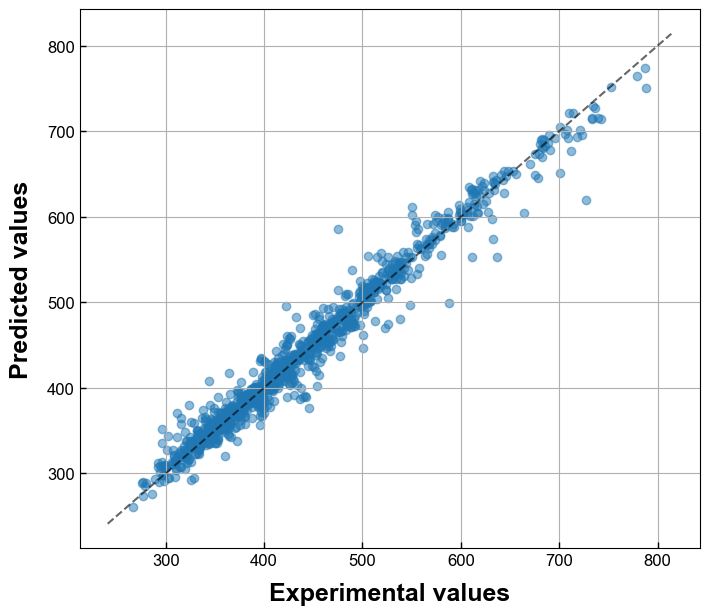

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

experiment_data = pd.read_csv('./Data/test-AM.csv')
prediction_data = pd.read_csv('test_predictions_AM.csv')

plt.figure(figsize=(8, 7))
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.scatter(experiment_data['AM'], prediction_data['AM'], alpha=0.5)
plt.xlabel('Experimental values', labelpad=10, fontweight='bold')
plt.ylabel('Predicted values', labelpad=10, fontweight='bold')
plt.tick_params(axis='x', direction='in', length=4, width=1)
plt.tick_params(axis='y', direction='in', length=4, width=1)

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.plot([xmin, xmax], [xmin, xmax], color='black', linestyle='--',alpha=0.6)

plt.grid(True)
plt.show()